In [23]:
import pandas as pd
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import numpy as np

# An algebraic backtesting framework

## The position type

The core of a general event-driven backtesting framework is either the *Position* or *Order* object, depending on timescales of interest, among other things. We will abstract this notion and define an abstract category of *Positions* and provide a minimal structure with which we can emulate trading activity. We begin first with a concrete implementation of the base *Position* type:

In [4]:
pdts = pd.Timestamp
@dataclass
class Position:
    ticker_symbol: str
    init_date: str or None
    shares: float
    roll_date : None = None
    id: int = field(default=-1, repr=False)
    def __post_init__(self):
        if not pdts(self.init_date).dayofweek < 5:
            raise Exception(f'{self.init_date} is a weekend')
    @property
    def is_open(self):
        if self.shares == 0:
            return False
        else:
            return True
    def __str__(self):
        return f"Position(Ticker: {self.ticker_symbol}, Shares: {self.shares}, "\
                   f"InitDate: {self.init_date}, RollDate: {self.roll_date})"
    def __bool__(self):
        return self.is_open
    def __hash__(self):
        self.id = hash((self.ticker_symbol, self.init_date))
        return self.id

Objects belonging to this dataclass are defined by a symbol and an entry date, as far as the ``__hash__`` method is concerned. Though abstractly, the category of *Positions* contain the tuple (symbol, entry date, size, roll date) as objects. Morphisms are defined as updates of the latter two tuple entries obeying some obvious causality and conservation rules.

In fact, what is natural is to give this category a monoidal structure defined by the natural binary operation (denoted by .) on positions is the addition or subtraction of shares of a base position (the position with 0 shares) on some roll date.  Fixing a symbol and entry date, we can define by the triple $((\text{symbol}, \text{entry date}),0, . )$ a position monoid.

### The position monoid

Since python is dynamically typed, we need an additional ingredient — the lift. In this context, a lift can be viewed as typecasting. For instance, a float can be lifted to type Position(symbol, date, .) through

```python
cast_to_pos = lambda q : Position(symbol, date, q)
```

We can now define the abstract monoid class:

In [5]:
class Monoid:
    def __init__(self, null, lift, binary_op):
        self.null = null
        self.lift = lift
        self.binary_op = binary_op

    def __call__(self, *args):
        _ = self.null
        for arg in args:
            arg = self.lift(arg)
            _ = self.binary_op(_, arg)
        return _

and, as an example, a SPY position monoid:

In [6]:
lift = lambda x: Position("SPY", '2020-02-05', *x)
base = lift((0, "2020-02-05"))
def add(a, b):
    if a.ticker_symbol == b.ticker_symbol:
        return Position(ticker_symbol=a.ticker_symbol, init_date=a.init_date,
                        roll_date=b.roll_date, shares=a.shares+b.shares)
    else:
        pass # Need an extension of the Position group

position_monoid = Monoid(base, lift, add)

We can appends to the base object (SPY, ‘2020–02–05’, 0) 2 shares on “2020–02–08” and 3 on “2020–02–10” — valid monoidal operations:

In [30]:
for update in [(2, "2020-02-08"), (-2, "2020-02-10")]:
    print(position_monoid(update))

Position(Ticker: SPY, Shares: 2, InitDate: 2020-02-05, RollDate: 2020-02-08)
Position(Ticker: SPY, Shares: -2, InitDate: 2020-02-05, RollDate: 2020-02-10)


You’ll notice that any open Position object has a natural inverse: Position(symbol, date, q)↦Position(symbol, date’, -q). It seems this idea can be leveraged to implement position closing. To add a bit more rigor to this notion, let us recall the definition of a terminal object in a category, C:

> An object $0\in C$ is the terminal object if $\exists!x\to 0$ for any $x\in C$. This unique map, if it exists, is the terminator.

If we assume date’ is ahead of date, we can take the composition with the forward dated inverse as yielding the base (0) object dated in the future which we interpret as the terminal object. The terminator in the monoidal position category corresponds to buy/sell to close operations.

In order to ensure initial and terminal objects are well defined, we need to do two things:

1. check that roll dates are never before the entry date
2. check if the created Position object is terminal.

At this level of abstraction, it might make the most sense to raise an exception when a terminal position is updated or when an update is dated before the entry date and handle them later.

## Logging and backtesting

It is important that we have a mechanism for dumping the sequence of actions we take into a trade log. One can do this by the standard logging functionality of python or take a more structured approach. We take the latter approach and create a pandas time series of holdings with the decorator

In [19]:
def log_positions(pd_series):
    def logger(func):
        def wrapper(a, b):
            pos = b
            if pos.roll_date:
                pd_series[pos.roll_date] = pos.shares
            else:
                pd_series[pos.init_date] = pos.shares
            # pd_series.fillna(inplace=True, method='ffill')
            return func(a, b)
        return wrapper
    return logger

which is to be applied to the monoid operation, ``add``:

In [42]:
series = pd.Series(index=pd.date_range(start='2020-02-05', end='2020-02-29'), dtype=float) # backtest interval
@log_positions(pd_series=series)
def add(a, b):
    if a.ticker_symbol == b.ticker_symbol:
        return Position(ticker_symbol=a.ticker_symbol, init_date=a.init_date,
                        roll_date=b.roll_date, shares=a.shares+b.shares)
    else:
        pass # Need an extension of the Position group

position_monoid = Monoid(base, lift, add)
for update in [(2, "2020-02-05"), (-7, "2020-02-10"), (2,  "2020-02-13"), (-2,  "2020-02-25")]:
    print(position_monoid(update))

Position(Ticker: SPY, Shares: 2, InitDate: 2020-02-05, RollDate: 2020-02-05)
Position(Ticker: SPY, Shares: -7, InitDate: 2020-02-05, RollDate: 2020-02-10)
Position(Ticker: SPY, Shares: 2, InitDate: 2020-02-05, RollDate: 2020-02-13)
Position(Ticker: SPY, Shares: -2, InitDate: 2020-02-05, RollDate: 2020-02-25)


Plotting positioning over time,

Text(0, 0.5, 'Trade signals')

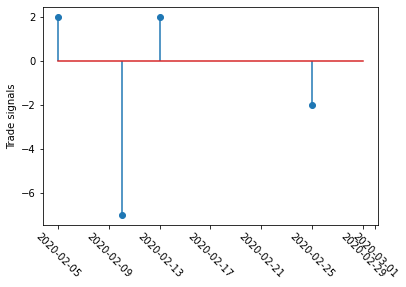

In [43]:
plt.figure()
plt.stem(series.index, series)
plt.xticks(rotation=-45)
plt.ylabel("Trade signals")

### Incorporating data

We now dress the position series with log returns:

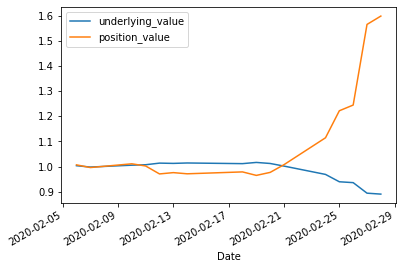

In [44]:
import pandas_datareader.data as web
hist = web.DataReader("SPY", 'yahoo','2020-02-05', '2020-02-29')
hist['LogRet'] = np.log(hist['Adj Close']).diff()
hist['Position'] = series
hist['CumsumPosition'] = np.cumsum(hist['Position'])
hist['CumsumPosition'].fillna(inplace=True, method='ffill')
hist['position_return'] = hist['CumsumPosition'].shift(1) * hist['LogRet']
hist['position_value'] = hist['position_return'].cumsum().apply(np.exp)
hist['underlying_value'] = hist['LogRet'].cumsum().apply(np.exp)
hist.drop(columns=['High', 'Low', 'Open', 'Close', 'Volume'], inplace=True)
hist[['underlying_value', 'position_value']].plot()
plt.savefig("sample_strat.png", dpi=400)
plt.show()

The plot shows the normalized price of SPY and the vectorized backtest of a strategy defined by the positions. As is hopefully clear, the transition from the abstract nonsense of monoids and categories to actionable ideas is almost immediate. To make this transition more clear we need only define a strategy as the sequence
$$
\mathcal P_{\sigma, t_0}(0, t_0)\to\mathcal P_{\sigma,t_0}(s_1, t_1)\to\cdots\to\mathcal P_{\sigma, t_0}(0, t_n)
$$
where $\sigma$ denotes the symbol, $t_0$ the entry date, $s_i$, $t_i$ for $i>0$ the shares and roll dates respectively. The next order of business is to implement the notion of a portfolio. The natural entry point of this generalization is the add method. We cannot add positions of two different symbols with what we have so far. However, it is clear that the structure closed with respect to the add operation for any symbol is simply a collection of unique position monoids.

The contents of this notebook are published on [medium](https://wire.insiderfinance.io/an-algebraic-framework-for-backtesting-i-4d2ace82276e)